# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Feature extraction](#Feature-extraction)
* [Results](#Results)

# Introduction

To speed development, 5-fold train-test splits were preprocessed and prepared as separate .feather files. This notebook uses LocalOutlierFactor to generate three scores per sample: one for each class. One would expect the argmin of those scores to be the correct class. The resultant scores may be considered newly extracted features or perhaps may be sufficient without the FRILL embeddings.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator

# Local Outlier Factor & PCA
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.29 s


In [4]:
# Location of CV .feather files
CV_FEATHERS_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 104 ms


# Feature extraction

In [5]:
VALENCE = {"neg": 0, "neu": 1, "pos": 2}
EMOS = ("neg", "neu", "pos")
NEIGHBORS = (10, 20, 30)


def make_PCA_columns(
    df: pd.DataFrame,
    neg_pca: BaseEstimator,
    neu_pca: BaseEstimator,
    pos_pca: BaseEstimator,
) -> pd.DataFrame:
    """Add the PCA-combo columns"""
    df["LOF-PCA_neg"] = neg_pca.transform(
        df[["LOF_neg_10", "LOF_neg_20", "LOF_neg_30"]]
    )
    df["LOF-PCA_neu"] = neu_pca.transform(
        df[["LOF_neu_10", "LOF_neu_20", "LOF_neu_30"]]
    )
    df["LOF-PCA_pos"] = pos_pca.transform(
        df[["LOF_pos_10", "LOF_pos_20", "LOF_pos_30"]]
    )
    return df


fold_num = 0
while True:
    fold_begin = time()

    # load training data
    try:
        X_train: pd.DataFrame = pd.read_feather(
            f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/X_train_untransformed.feather"
        )
        y_train: pd.Series = pd.read_feather(
            f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/y_train_untransformed.feather"
        ).iloc[:, 0]
        X_test: pd.DataFrame = pd.read_feather(
            f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/X_test_untransformed.feather"
        )
    except FileNotFoundError:
        break

    # get LOF scores for X_train and X_test
    train_LOF_scores, test_LOF_scores = {}, {}
    # extract one feature at a time
    for n_neighbors in NEIGHBORS:
        for emo in ("neg", "neu", "pos"):
            valence = VALENCE[emo]
            key = f"LOF_{emo}_{n_neighbors}"
            X_train[key] = np.nan
            LOF = LocalOutlierFactor(n_neighbors, novelty=True, n_jobs=-1).fit(
                X_train.drop(columns=key).loc[y_train == valence].values
            )
            X_train.loc[y_train == valence, key] = LOF.negative_outlier_factor_
            X_train.loc[y_train != valence, key] = LOF.score_samples(
                X_train.drop(columns=key).loc[y_train != valence]
            )
            train_LOF_scores[key] = X_train.pop(key)
            test_LOF_scores[key] = LOF.score_samples(X_test)
            del LOF
            del valence
            del key
            _ = gc_collect()

    del X_train
    del X_test
    del y_train
    _ = gc_collect()

    # collect train scores
    df = pd.concat(train_LOF_scores, axis="columns")
    del train_LOF_scores
    _ = gc_collect()

    # PCA-reduce columns with same valence
    make_PCA = lambda: PCA(n_components=1, random_state=SEED)
    selector = lambda emo: [f"LOF_{emo}_{k}" for k in (10, 20, 30)]
    neg_pca = make_PCA().fit(df[selector("neg")])
    neu_pca = make_PCA().fit(df[selector("neu")])
    pos_pca = make_PCA().fit(df[selector("pos")])
    del make_PCA
    del selector
    _ = gc_collect()

    # save train data
    make_PCA_columns(df, neg_pca, neu_pca, pos_pca).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_train_LOF_scores.feather"
    )

    # collect & process test scores
    make_PCA_columns(
        pd.DataFrame(test_LOF_scores), neg_pca, neu_pca, pos_pca
    ).to_feather(f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_test_LOF_scores.feather")
    del test_LOF_scores
    _ = gc_collect()

    print(f"fold {fold_num + 1} completed in {time() - fold_begin:.2f} s")
    del fold_begin
    _ = gc_collect()

    fold_num += 1

fold 1 completed in 1579.86 s
fold 2 completed in 1633.16 s
fold 3 completed in 1493.78 s
fold 4 completed in 1358.67 s
fold 5 completed in 1556.02 s
time: 2h 7min 2s


# Results

Let's peek at the results.

,LOF_neg_10,LOF_neu_10,LOF_pos_10,LOF_neg_20,LOF_neu_20,LOF_pos_20,LOF_neg_30,LOF_neu_30,LOF_pos_30,LOF-PCA_neg,LOF-PCA_neu,LOF-PCA_pos
0,-1.031824,-1.239730,-1.155934,-1.043563,-1.274530,-1.152866,-1.069915,-1.299637,-1.149574,0.092365,-0.153825,-0.032931
1,-1.137058,-1.395842,-1.204412,-1.210620,-1.730531,-1.251072,-1.303141,-1.714563,-1.284180,-0.201181,-0.746083,-0.193278
2,-1.048978,-1.174958,-1.072404,-1.105622,-1.115392,-1.068511,-1.095114,-1.094940,-1.077549,0.031638,0.093003,0.105786
3,-1.051166,-1.344597,-1.190348,-1.080411,-1.333304,-1.217408,-1.093578,-1.326845,-1.228011,0.046082,-0.264375,-0.134297
4,-1.151616,-1.333052,-1.237364,-1.163949,-1.331396,-1.203531,-1.167506,-1.357875,-1.191916,-0.102390,-0.274264,-0.134466


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70220 entries, 0 to 70219
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LOF_neg_10   70220 non-null  float64
 1   LOF_neu_10   70220 non-null  float64
 2   LOF_pos_10   70220 non-null  float64
 3   LOF_neg_20   70220 non-null  float64
 4   LOF_neu_20   70220 non-null  float64
 5   LOF_pos_20   70220 non-null  float64
 6   LOF_neg_30   70220 non-null  float64
 7   LOF_neu_30   70220 non-null  float64
 8   LOF_pos_30   70220 non-null  float64
 9   LOF-PCA_neg  70220 non-null  float64
 10  LOF-PCA_neu  70220 non-null  float64
 11  LOF-PCA_pos  70220 non-null  float64
dtypes: float64(12)
memory usage: 6.4 MB


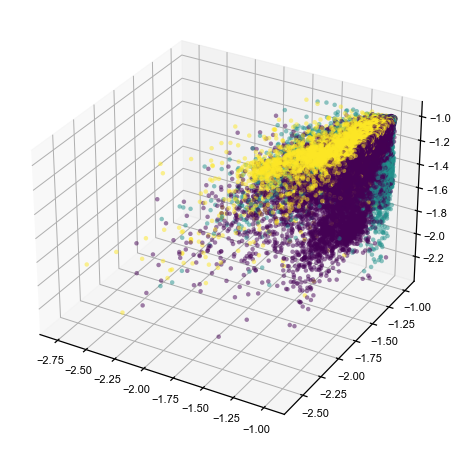

time: 1.16 s


In [6]:
_ = pd.read_feather("./cv_4/X_train_LOF_scores.feather")
_.head(5)
_.info()
_labels = pd.read_feather("./cv_4/y_train_untransformed.feather").iloc[:, 0]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
sns.set_style("ticks")
ax.scatter(
    _.LOF_neg_10,
    _.LOF_neu_10,
    _.LOF_pos_10,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=_labels,
)
plt.show()

,LOF_neg_10,LOF_neu_10,LOF_pos_10,LOF_neg_20,LOF_neu_20,LOF_pos_20,LOF_neg_30,LOF_neu_30,LOF_pos_30,LOF-PCA_neg,LOF-PCA_neu,LOF-PCA_pos
0,-1.220915,-1.438089,-1.147895,-1.207673,-1.664292,-1.184690,-1.193781,-1.675200,-1.214034,-0.158865,-0.705358,-0.056253
1,-1.378690,-1.456923,-1.328019,-1.392400,-1.403008,-1.335087,-1.371297,-1.392226,-1.308563,-0.459483,-0.402385,-0.302367
2,-1.211388,-1.391155,-1.237380,-1.233865,-1.374023,-1.263351,-1.210304,-1.342740,-1.254670,-0.178670,-0.319219,-0.177230
3,-1.348632,-1.606036,-1.343853,-1.352965,-1.502922,-1.340881,-1.344571,-1.514387,-1.300769,-0.403907,-0.616574,-0.310548
4,-1.173027,-1.313648,-1.207866,-1.141930,-1.320956,-1.200528,-1.187037,-1.364533,-1.195085,-0.089742,-0.255899,-0.089675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LOF_neg_10   11524 non-null  float32
 1   LOF_neu_10   11524 non-null  float32
 2   LOF_pos_10   11524 non-null  float32
 3   LOF_neg_20   11524 non-null  float32
 4   LOF_neu_20   11524 non-null  float32
 5   LOF_pos_20   11524 non-null  float32
 6   LOF_neg_30   11524 non-null  float32
 7   LOF_neu_30   11524 non-null  float32
 8   LOF_pos_30   11524 non-null  float32
 9   LOF-PCA_neg  11524 non-null  float32
 10  LOF-PCA_neu  11524 non-null  float32
 11  LOF-PCA_pos  11524 non-null  float32
dtypes: float32(12)
memory usage: 540.3 KB


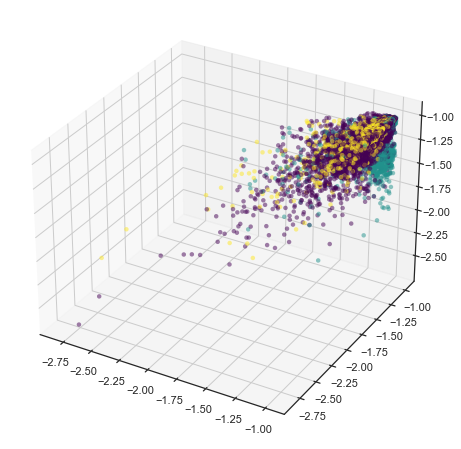

time: 534 ms


In [7]:
_ = pd.read_feather("./cv_1/X_test_LOF_scores.feather")
_.head(5)
_.info()
_labels = pd.read_feather("./cv_1/y_test_untransformed.feather").iloc[:, 0]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
sns.set_style("ticks")
ax.scatter(
    _.LOF_neg_20,
    _.LOF_neu_20,
    _.LOF_pos_20,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=_labels,
)
plt.show()

,LOF_neg_10,LOF_neu_10,LOF_pos_10,LOF_neg_20,LOF_neu_20,LOF_pos_20,LOF_neg_30,LOF_neu_30,LOF_pos_30,LOF-PCA_neg,LOF-PCA_neu,LOF-PCA_pos
0,-1.275138,-1.399438,-1.329507,-1.328032,-1.473752,-1.313688,-1.357867,-1.454859,-1.355732,-0.366001,-0.445998,-0.322484
1,-1.276974,-1.505448,-1.438920,-1.287467,-1.515030,-1.549788,-1.356313,-1.476693,-1.503924,-0.342295,-0.544522,-0.607891
2,-1.026287,-1.298440,-1.077092,-1.025231,-1.317827,-1.075758,-1.021108,-1.297862,-1.066358,0.148396,-0.207592,0.127069
3,-1.037506,-1.265773,-1.148864,-1.060495,-1.230146,-1.204321,-1.084973,-1.239772,-1.209977,0.083790,-0.104656,-0.070986
4,-1.244009,-1.252042,-1.279142,-1.254857,-1.276829,-1.241414,-1.230755,-1.293177,-1.230821,-0.230782,-0.153840,-0.180359


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19319 entries, 0 to 19318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LOF_neg_10   19319 non-null  float32
 1   LOF_neu_10   19319 non-null  float32
 2   LOF_pos_10   19319 non-null  float32
 3   LOF_neg_20   19319 non-null  float32
 4   LOF_neu_20   19319 non-null  float32
 5   LOF_pos_20   19319 non-null  float32
 6   LOF_neg_30   19319 non-null  float32
 7   LOF_neu_30   19319 non-null  float32
 8   LOF_pos_30   19319 non-null  float32
 9   LOF-PCA_neg  19319 non-null  float32
 10  LOF-PCA_neu  19319 non-null  float32
 11  LOF-PCA_pos  19319 non-null  float32
dtypes: float32(12)
memory usage: 905.7 KB


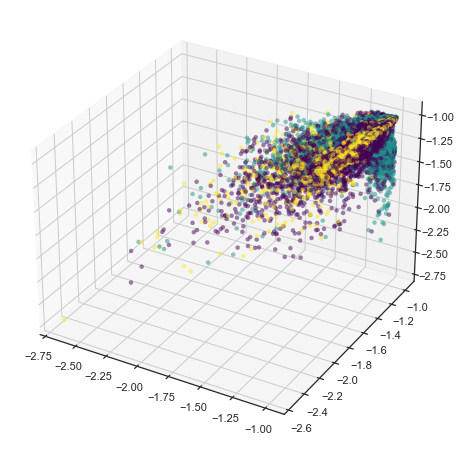

time: 495 ms


In [8]:
_ = pd.read_feather("./cv_2/X_test_LOF_scores.feather")
_.head(5)
_.info()
_labels = pd.read_feather("./cv_2/y_test_untransformed.feather").iloc[:, 0]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
sns.set_style("ticks")
ax.scatter(
    _.LOF_neg_30,
    _.LOF_neu_30,
    _.LOF_pos_30,
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=_labels,
)
plt.show()

,LOF_neg_10,LOF_neu_10,LOF_pos_10,LOF_neg_20,LOF_neu_20,LOF_pos_20,LOF_neg_30,LOF_neu_30,LOF_pos_30,LOF-PCA_neg,LOF-PCA_neu,LOF-PCA_pos
0,-0.999647,-1.221347,-1.085096,-1.020131,-1.271256,-1.132208,-1.029875,-1.284616,-1.157220,0.162653,-0.133440,0.026004
1,-0.996130,-1.279717,-1.083079,-1.007643,-1.294341,-1.081078,-1.022074,-1.286327,-1.094845,0.176514,-0.181299,0.092645
2,-1.085261,-1.174504,-1.197300,-1.123667,-1.201654,-1.235010,-1.128212,-1.225070,-1.206874,-0.003570,-0.031664,-0.127169
3,-1.119017,-1.349240,-1.189231,-1.136017,-1.346823,-1.202581,-1.165340,-1.534879,-1.229842,-0.051491,-0.394493,-0.116631
4,-1.057285,-1.240786,-1.142063,-1.062568,-1.246343,-1.132359,-1.061732,-1.246357,-1.133431,0.086938,-0.107957,0.006624


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73258 entries, 0 to 73257
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LOF_neg_10   73258 non-null  float64
 1   LOF_neu_10   73258 non-null  float64
 2   LOF_pos_10   73258 non-null  float64
 3   LOF_neg_20   73258 non-null  float64
 4   LOF_neu_20   73258 non-null  float64
 5   LOF_pos_20   73258 non-null  float64
 6   LOF_neg_30   73258 non-null  float64
 7   LOF_neu_30   73258 non-null  float64
 8   LOF_pos_30   73258 non-null  float64
 9   LOF-PCA_neg  73258 non-null  float64
 10  LOF-PCA_neu  73258 non-null  float64
 11  LOF-PCA_pos  73258 non-null  float64
dtypes: float64(12)
memory usage: 6.7 MB


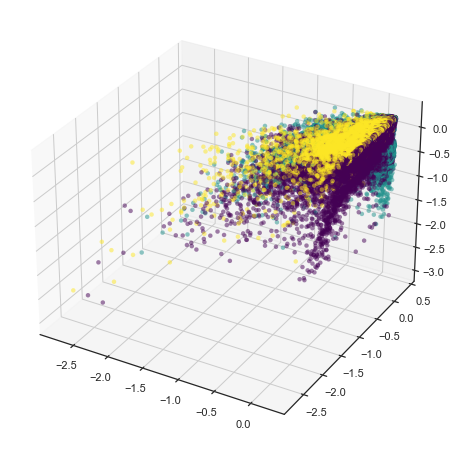

time: 829 ms


In [9]:
_ = pd.read_feather("./cv_0/X_train_LOF_scores.feather")
_.head(5)
_.info()
_labels = pd.read_feather("./cv_0/y_train_untransformed.feather").iloc[:, 0]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
sns.set_style("ticks")
ax.scatter(
    _["LOF-PCA_neg"],
    _["LOF-PCA_neu"],
    _["LOF-PCA_pos"],
    alpha=0.5,
    linewidth=0,
    cmap="viridis",
    c=_labels,
)
plt.show()

In [10]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 7632.779189348221 s
time: 107 ms


[^top](#Contents)